# Principled Amortized Bayesian Workflow for Cognitive Modeling
by Lukas Schumacher & Stefan T. Radev

## Table of Contents
 * [Introduction](#introduction)
 * [Generative Model Specification](#generative_model_specification)
	 * [Creating a Simulator](#creating_a_simulator)
	 * [Defining Prior Distributions](#defining_prior_distributions)
	 * [Context Variables for General Amortized Inference](#context_variables_for)
	 * [Simulator](#simulator)
 * [Prior Pushforward Check](#prior_pushforward_check)
 * [Defining the Neural Approximator](#defining_the_neural)
	 * [Summary Network](#summary_network)
	 * [Inference Network](#inference_network)
	 * [Amortized Posterior](#amortized_posterior)
 * [Defining the Configurator](#defining_the_configurator)
 * [Defining the Trainer](#defining_the_trainer)
 * [Training Phase](#training_phase)
 * [Validation](#validation)
	 * [Simulation-Based Calibration](#simulation_based_calibration)
	 * [Model Sensitivity](#model_sensitivity)
	 * [Posterior Retrodictive Checks in Silico](#posterior_retrodictive_checks)
 * [Inference Phase](#inference_phase)
 * [Further Experimentation](#further_experimentation)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import bayesflow as bf

In [5]:
# Suppress scientific notation for floats
np.set_printoptions(suppress=True)

In [6]:
try:
    from numba import njit
except ModuleNotFoundError as err:
    print("Please run `!pip install numba` and restart the kernel for utilizing just-in-time compilation.")

## Introduction <a class="anchor" id="introduction"></a>

Psychological research often relies on mathematical models to explain and predict human behavior.
Such models aim to formalize cognitive processes by mapping latent psychological constructs to model parameters and specifying how these generate manifest data. In this tutorial, we go through the steps of a principled [Bayesian workflow](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html) that is imperative when developing and applying cognitive models.
This workflow includes the following steps:

1. Prior pushforward and prior predictive checks to assess whether the model is consistent with our domain expertise;
2. Computational faithfulness checks to ensure that our estimation method can accurately approximate the posterior distributions;
3. Model sensitivity to examine if our inferences provide sufficient information for answering our research question;
4. Posterior retrodictive checks to assess whether our model can capture the relevant structure of the true data-generating process;

To demonstrate how such a workflow is performed in an amortized manner using **BayesFlow**, we will take a complex model from the evidence accumulaton model (EAM) family which is intractable for standard Bayesian methods.

## Generative Model Specification <a class="anchor" id="generative_model_specification"></a>


Evidence accumulation models (EAM) are among the most commonly used cognitive models in psychological research. These decision models account for both choice and response time data by assuming that cognitive agents accumulate evidence for decision alternatives until an internal threshold is reached. This process is typically formalized as a random walk with drift. The standard EAM has four core parameters, each corresponding to a specific latent cognitive construct: i) the drift rate $v$ represents perceptual processing speed; ii) the threshold $a$ reflects decision caution; iii) the starting point $\beta$ determines decisional biases, and iv) the non-decision time $\tau$ accounts for decision-unrelated processes such as motor actions and perceptual encoding.

There are many model variations within the EAM class. Througout this tutorial, we will focus on the leaky competing accumulator (LCA) model proposed by [Usher and McClelland (2001)](https://psycnet.apa.org/record/2001-07628-003). The likelihood function of this model is not known in closed form. This makes it a perfect candidate for <tt>BayesFlow</tt>, as it can handle any model that can be implemented as a randomized data simulator.

The LCA assumes a competition between seperate accumulators $A_j$, each corresponding to a decision alternative $j$. The accumulator $A_j$ that first hits its threshold wins and the corresponding decision will be made. Evidence accumulation for a certain decision alternative follows a Wiener process with two additional features: 
1) Evidence leakage or decay $\lambda$ that accounts for information loss over time within each accumulator
2) Lateral inhibition $\kappa$, which represents accumulator activation damping from the other accumulators. 

The activiation of a single accumulator $x_j$ is thus updated as follow:

$$
\begin{align}
\mathrm{d}x_j &= \left(v_j - \lambda x_j - \kappa \sum_{j'\neq j} x_{j'}\right)\mathrm{d}t + \xi \sqrt{\mathrm{d}t}
\quad\text{with}\quad \xi\sim\mathcal{N}(0, 1)\\
x_j &=\mathrm{max}(x_j, 0)
\end{align}
$$

This process continues until one of the accumulator's activations exceeds a fixed threshold $a$. The decision corresponding to the accumulator that reached its threshold first will be made. The first-passage time, including a constant shift $\tau$ for non-decisional processes, determines the response time. For simplicity, we assume that all accumulators start at $0$, so we do not account for an *a priori* bias towards a particular decision alternative. Thus, our LCA version has the following free parameters:

* Drift rates $v_j$
* Threshold $a$
* Non-decision time $\tau$
* Decay $\lambda$
* Inhibition $\kappa$

### Creating a Simulator <a class="anchor" id="creating_a_simulator"></a>


Now, let us specify the LCA as a randomized data simulator. For this function we use the `@njit` decorator from the [Numba](https://numba.pydata.org/) module to speed up simulation time.

In [8]:
@njit
def lca_trial(v, a, ndt, la, ka, dt=1e-3, s=1.0, max_iter=1e5):
    """Generates a response time and choice from the LCA model given a set of parameters."""

    # get number of decision alternatives
    num_alternatives = len(v)
    # constant for diffusion process
    c = np.sqrt(dt * s)
    # initialize accumulator activations
    x = np.zeros(num_alternatives)
    # accumulation process
    num_iter = 0
    while np.all(x < a) and num_iter < max_iter:
        # iterate over accumulators
        for i in range(num_alternatives):
            x[i] = max(0.0, (x[i] + (v[i] - la * x[i] - ka * (np.sum(x) - x[i])) * dt + c * np.random.randn()))
        num_iter += 1
    # determine respnose time and choice
    rt = num_iter * dt + ndt
    if num_iter < max_iter:
        resp = float(np.where(x >= a)[0][0])
    else:
        resp = -1.0
    return rt, resp

This function returns a single response time and choice. It is generally written and can be used for all decisions between two or more alternatives. Let's test it in the case of three alterantives with some randomly chosen parameter values. Note: Expect the very first call to the function to take more time due to compilation.

In [9]:
rt, resp = lca_trial(v=np.array([1, 1, 1]), a=1.5, ndt=0.3, la=0.1, ka=0.1)
print(rt, resp)

0.849 1.0


### Defining Prior Distributions <a class="anchor" id="defining_prior_distributions"></a>


Next, we specify prior distributions for the LCA parameters. We want to bound all the parameters to possible values. We also want that most of the mass of the prior distributions lies on plausible values we know from domain expertice. All LCA parameters should be positive values. The leak and decay parameter are further bounded within $[0, 1]$. Thus, we use Gamma distributions for the drift rates, threshold, and non-decision time. For the leak and decay parameter we use Beta distributions.

Further down we will create an experimental context for a hypothetical decision making task between three alternatives and two conditions. Let us imagine that the experimental manipulation is expected to affect only the drift rates. Thus, we need three drift rates (one for each alternative) for each condition, resulting in a total of six separate drift rates.

In [10]:
RNG = np.random.default_rng(2023)

In [11]:
def lca_prior(num_alternatives=3, num_conditons=2):
    "Generates a random draw from the joint prior distribution."

    drifts = RNG.gamma(2, 1 / 1.2, size=num_alternatives * num_conditons)
    threshold = RNG.gamma(10, 1 / 6)
    ndt = RNG.gamma(1.5, 1 / 5.0)
    decay = RNG.beta(1, 5)
    inhibition = RNG.beta(1, 5)
    return np.hstack((drifts, threshold, ndt, decay, inhibition))

Lets pass our ``lca_prior`` function to BayesFlow's ``Prior`` wrapper.

In [12]:
PARAM_NAMES = [
    r"$v_{1,1}$",
    r"$v_{1,2}$",
    r"$v_{1,3}$",
    r"$v_{2,1}$",
    r"$v_{2,2}$",
    r"$v_{2,3}$",
    r"$a$",
    r"$\tau$",
    r"$\lambda$",
    r"$\kappa$",
]

In [13]:
prior = bf.simulation.Prior(prior_fun=lca_prior, param_names=PARAM_NAMES)

We can now sample from our joint prior distribution by calling the prior class with the batch_size argument.

In [14]:
prior(batch_size=1)

{'prior_draws': array([[2.14202107, 0.37964542, 0.71023643, 1.18597077, 0.81592505,
         1.44358328, 1.68055805, 0.33196847, 0.29361842, 0.17988274]]),
 'batchable_context': None,
 'non_batchable_context': None}

This returns a dictionary containing a single prior draw. In addition to the prior draws the dictionary contains ``batchable_context`` and ``non_batchable_context`` keys. These variables allow the prior function to accept context information based on which the behavior of the function can be modified (e.g., for conditional priors). In our use case, we do not have variables that influence the prior function. More details on the functionality and usablity of these context variables follow in the next chapter. 

The `Prior` wrapper comes with some handy functionalities. For instance, we can simply inspect our prior distributions by plotting some prior draws with the method `plot_prior2d()`.

In [11]:
f = prior.plot_prior2d(n_samples=500)

### Context Variables for General Amortized Inference <a class="anchor" id="context_variables_for"></a>


A generative model, in addition to prior and simulator, also incorporates various contextual factors that affect the data generation process. These contextual assumptions are often specific to the field of study and can include elements such as experimental conditions, number of observations, and subject-specific factors.

`BayesFlow` distinguishes between two types of context variables: `batchable_context` and `non_batchable_context`. This distinction is purely technical, rather then conceptual:
* Batchable context variables differ for each simulation in each training batch of simulations;
* Non-batchable context variables stay the same for each simulation in a batch, but differ across simulated batches;

Examples for **batchable** context variables include experimental design variables, design matrices, etc.
Examples for **non-batchable** context variables include the number of observations in an experiment, positional encodings, time indices, etc. While the latter can also be considered batchable in principle, batching them would require non-Tensor (i.e., non-rectangular) data structures, which usually means inefficient computations. 

For this tutorial, I want to define one **non-batchable** and one **batchable** context variable that affect the simulator, but not the prior function. Let us imagine a hypothetical three-alternative decision-making task. In this task, two different stimuli are shown. We assume that this experimental manipulation affects the rate of evidence accumulation of the three accumulators. To simulate this experimental manipulation, we can define a function that creates randomly interleaved condition indicators for an experiment with let's say $500$ trials. This condition variable is **batchable**, because it will vary for each simulation in a given batch.

In practice, it's common to encounter missing trials in psychological research due to various reasons such as a participant's attentional lapses or experimental errors. Therefore, it's also important to train our networks with a varying number of observations. This approach will make sure that the model can also be fit to data sets with missing data. Let us create a function that randomly samples a number of observations between $200$ and $300$. This condition variable is not batchable, because if we have different number of observations within a batch, then we don't get a rectangular multi-dimensional array of `size=(batch_size, n_obs, data_dim)`.

**Important:** Since the posterior will also depend on all context variables, these need to be passed to the inference network through a `configurator` function (described below).

In [18]:
MIN_OBS = 200
MAX_OBS = 300
NUM_CONDITIONS = 2

In [19]:
def random_num_obs(min_obs=MIN_OBS, max_obs=MAX_OBS):
    """Draws a random number of observations for all simulations in a batch."""

    return RNG.integers(low=min_obs, high=max_obs + 1)

In [20]:
def generate_condition_matrix(num_obs, num_conditons=NUM_CONDITIONS):
    """Draws a random design matrix for each simulation in a batch."""

    obs_per_condition = np.ceil(num_obs / num_conditons)
    condition = np.arange(num_conditons)
    condition = np.repeat(condition, obs_per_condition)
    return condition[:num_obs]

Let us pass the `generate_condition_matrix` and the `random_num_obs` function to BayesFlow's `ContextGenerator` wrapper. In order to use the output of the `random_num_obs` function, which is the number of observations, and is needed by the `generate_condition_matrix` function, we have to set the `use_non_batchable_for_batchable` argument to `True`.

In [21]:
context_gen = bf.simulation.ContextGenerator(
    non_batchable_context_fun=random_num_obs,
    batchable_context_fun=generate_condition_matrix,
    use_non_batchable_for_batchable=True,
)

In [22]:
context_gen(1)

{'non_batchable_context': 220,
 'batchable_context': [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]}

As you can see, the randomly sampled number of observation is constant within a batch of 2 simulated experimental contexts, but the order of the experimental conditions is different between the contexts.

**Important**: Since the model assumes that the observed response times are generated exchangeably (i.e., IID) and we will be using a permutation-invariant `DeepSet` for compressing the simulations, the order of the generated condition indicators is not important. Thus, we don't need to shuffle the condition indicators, even though these may have a different order in the real data set.

### Simulator <a class="anchor" id="simulator"></a>


Next, we create a function that repeatetly calls the `lca_trial` function to simulate the performance of a single subject in a whole experiment given a set of parameter values and context variables. Again, we use the `@njit` decorator to improve the speed of the core data simulation function, which will be heavily used during training.

Note, that in addition to the vector of parameters, our simulator takes the design matrix (i.e., batchable context) and the number of observations (i.e., non-batchable context) as arguments.

In [23]:
@njit
def lca_experiment(theta, design_matrix, num_obs):
    """Simulates data from a single subject in a multi-alternative response times experiment."""

    num_alternatives = int((len(theta) - 4) / NUM_CONDITIONS)
    v = theta[: num_alternatives * NUM_CONDITIONS]
    v = np.split(v, NUM_CONDITIONS)
    out = np.zeros((num_obs, 2))
    for n in range(num_obs):
        out[n, :] = lca_trial(v[design_matrix[n]], theta[-4], theta[-3], theta[-2], theta[-1])
    return out

Let's pass the ``lca_experiment`` function and the context generator to BayesFlow's ``Simulator`` wrapper.

In [24]:
simulator = bf.simulation.Simulator(simulator_fun=lca_experiment, context_generator=context_gen)

We have now defined all the building blocks of a generative model, namely a randomized data generator, prior distributions, and a experimental context. We can now combine all the parts to form a generative model by using BayesFlow's ``GenerativeModel`` class.

In [25]:
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator, name="LCA")

INFO:root:Performing 2 pilot runs with the LCA model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 296, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable context: ()
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes cares of that!


The usage of the `Prior`, `Simulator`, and `GenerativeModel` wrappers is not mandatory. These are only provided for convinience and should cover the basic use cases. You are free to implement your own generative models in any way you want, as long as their outputs can interact with BayesFlow's objects.

Let us simulate a batch of $10$ data sets with $10$ randomly sampled parameter sets and generated contexts.

In [26]:
example_sim = model(batch_size=10)

We get a dictionary with everything we need:
* Prior draws
* Batchable and non-batchable context for the simulator
* Simulated response times and choice data

## Prior Pushforward Check <a class="anchor" id="prior_pushforward_check"></a>


Now that we have specified a fully-flegded cognitive model, we want to check whether the generative model with its (prior) assumptions produces sensible data that could be oberseved in the real world. To this end, we just simulate some data sets and inspect the joint response time distribution.

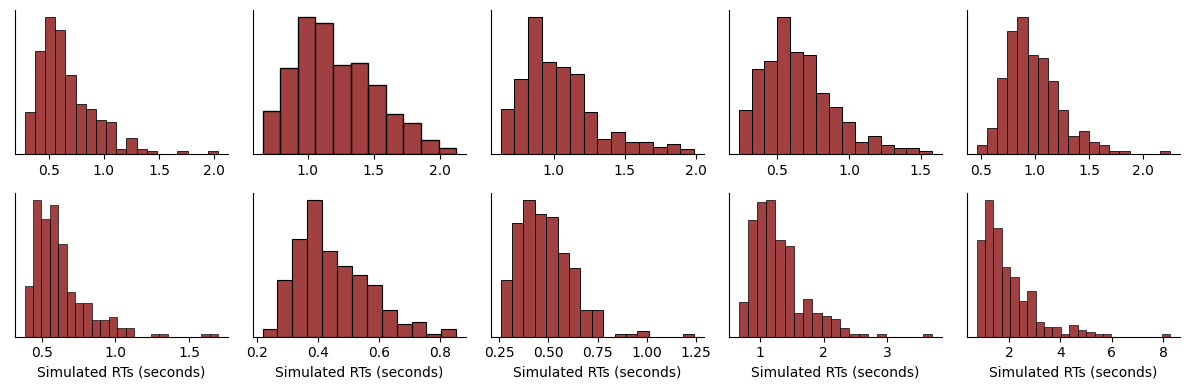

In [37]:
f, axarr = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in enumerate(axarr.flat):
    sns.histplot(example_sim["sim_data"][i, :, 0].flatten(), color="maroon", alpha=0.75, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("")
    ax.set_yticks([])
    if i > 4:
        ax.set_xlabel("Simulated RTs (seconds)")
f.tight_layout()

The model generates skewed RT distributions which are commonly observed in empricial response time experiments. We also do not detect any unusual or implausible values such as negative response times or excessively high values. In practice, you would perform these checks over multiple simulations from the prior predictive and try to distil the information through informative *summary statistics* of the data. Basically, you are trying to answer the following question: What assumptions do my prior and likelihood specification encode regarding the data-generating process and its typical scope? 

The next step in our workflow is to conduct model sensitivity and computational faithfulness checks. This involves fitting our LCA model to simulated data and then using the obtained parameters to predict these data through resimulation. Before we can proceed with this step, we first need to train our neural networks.

## Defining the Neural Approximator <a class="anchor" id="defining_the_neural"></a>


### Summary Network <a class="anchor" id="summary_network"></a>


Although we simulate randomly interleaved experimental manipulation, we are not really interested in any sequential effects during the hypothetical decision task. Therefore, we can treat our data as exchangeable and use a `SetTransformer` for the summary network. This invariant neural network respects the permutation invariance of the data. It takes (at least) 3D tensors of shape `(batch_size, n_obs, data_dim)` and reduce them to 2D tensors of shape `(batch_size, summary_dim)`, where `summary_dim` is a hyperparameter to be set by us. Heuristically, this number should not be lower than the number of parameters in a model. Below, we create a deep permutation-invariant network with `summary_dim=32`:

In [39]:
summary_net = bf.networks.SetTransformer(input_dim=5, summary_dim=32, name="lca_summary")

The `input_dim=5` setting is due to the fact that the configured data will have $5$ dimensions (last axis): the continuous RT, the $3$-dimensional one-hot encoding of the $3$ choices, and a binary condition indicator.

### Inference Network <a class="anchor" id="inference_network"></a>


The conditional invertible neural network (cINN) is the key component of our amortized posterior inference framework. The only mandatory hyperparameter for the cINN is the number of parameters to be estimated. However, other hyperparameters, such as the number of coupling layers, can also be adjusted and these may be kay for getting the best our of your inference networks. For an actual application, you may want to experiment with these settings on an offline "development" set of simulations.

In [40]:
inference_net = bf.networks.InvertibleNetwork(
    num_params=len(prior.param_names),
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
    name="lca_inference",
)

Note also, that we are turning off the kernel and dropout regularization for the networks, since we don't need these for online training (overfitting is impossible if the networks never see the same simulated data set twice during training).

### Amortized Posterior <a class="anchor" id="amortized_posterior"></a>


We can now connect the summary and inference networks via the `AmortizedPosterior` wrapper:

In [41]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, name="lca_amortizer")

## Defining the Configurator <a class="anchor" id="defining_the_configurator"></a>


A configurator acts as an intermediary between a generative model and an amortizer. Here we should do mainly two things:
1. Bring the output of the generative model (simulated data, context, prior draws) into a suitable format for processing with neural networks.
2. Transformations of data and/or parameters.

In the following we will do both. Firsty, our simulated data sets have two dimensions ``(n_obs, data_dim)``. ``data_dim = 2`` consists of response times and choices. The choice variable is categorical and can be either $0$, $1$, or $2$, because there are three alternatives in the imagined decision task. When working with neural networks, categorical variables always have to be one-hot encoded (dummy-coded). In addition, we also have to pass the context information to the neural networks. As we only have two conditions this variable is already dummy coded and we simply append it to the two dimensional data array. This will extend the ``data_dim`` to $5$ (one for rts, three for responses, one for context).

Secondly, we also want to standardize the data generating parameters before we pass them to the neural network.

In order to standardize the parameters we need the mean and standard deviation of our prior distributions. We can get them with another handy method from BayesFlow's ``prior`` class.

In [42]:
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=100000)
prior_means = np.round(prior_means, decimals=1)
prior_stds = np.round(prior_stds, decimals=1)

In [43]:
from tensorflow.keras.utils import to_categorical


def configurator(forward_dict):
    """Configure the output of the GenerativeModel for a BayesFlow setup."""

    # Prepare placeholder dict
    out_dict = {}

    # Extract simulated response times
    data = forward_dict["sim_data"]

    # Convert list of condition indicators to a 2D array and add a
    # trailing dimension of 1, so shape becomes (batch_size, num_obs, 1)
    # We need this in order to easily concatenate the context with the data
    context = np.array(forward_dict["sim_batchable_context"])[..., None]

    # One-hot encoding of integer choices
    categorical_resp = to_categorical(data[:, :, 1], num_classes=3)

    # Concatenate rt, resp, context
    out_dict["summary_conditions"] = np.c_[data[:, :, :1], categorical_resp, context].astype(np.float32)

    # Make inference network aware of varying numbers of trials
    # We create a vector of shape (batch_size, 1) by repeating the sqrt(num_obs)
    vec_num_obs = forward_dict["sim_non_batchable_context"] * np.ones((data.shape[0], 1))
    out_dict["direct_conditions"] = np.sqrt(vec_num_obs).astype(np.float32)

    # Get data generating parameters
    params = forward_dict["prior_draws"].astype(np.float32)

    # Standardize parameters
    out_dict["parameters"] = (params - prior_means) / prior_stds

    return out_dict

Our `configurator` returns a pre-processed dictionary with three keys:
1. `parameters` - These are the quantities over which we want to perform posterior inference.
2. `summary_conditions` - These are the quantities that go into the summary network (i.e., data and further context) before being passed as a condition for the inference network.
3. `direct_conditions` - These are the quantities that bypass the summary network and are passed directly as conditions for the inference network.

In other words, `direct_conditions` will simply be concatenated to the summary network outputs so the final condition vector for the inference network is `(summary_net_outputs, direct_conditions)`. Note, that you can also use only `summary_conditions` in case there are no direct ones, or only `direct_conditions` in case you are working with data that does not benefit from compression.

## Defining the Trainer <a class="anchor" id="defining_the_trainer"></a>


Now, it is time to define the `Trainer` instance. We simply pass the generatvie model, the amortizer, and our configurator. Usually, we want to define a `checkpoint_path`, so the neural approximator will be saved automatically to this path and will be loaded the next time you create the `trainer`. Otherwise, neural approximators must be manually saved using, for instance, TensorFlow's `amortizer.save_weights()` method, or separately saving the summary and inference networks.

In [44]:
trainer = bf.trainers.Trainer(
    generative_model=model, amortizer=amortizer, configurator=configurator, checkpoint_path="lca_model"
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
2023-07-16 10:34:27.249261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
INFO:root:Done.


When we initiate the trainer it informs us whether a consistency check (i.e., simulation -> configuration -> transformation -> loss computation) was successful. In our case, we passed the check and are now ready to train our neural networks.

We can also check out the number of trainable neural network parameters for the composite approximator:

In [45]:
amortizer.summary()

Model: "lca_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lca_inference (InvertibleNe  multiple                 531816    
 twork)                                                          
                                                                 
 lca_summary (SetTransformer  multiple                 63608     
 )                                                               
                                                                 
Total params: 595,424
Trainable params: 595,304
Non-trainable params: 120
_________________________________________________________________


## Training Phase <a class="anchor" id="training_phase"></a>

With the help of ``numba`` our simulator is relatively fast. Thus, we can safely go with online training. Let's glean the time taken for a batch of $32$ simulations:

In [46]:
%%time
_ = model(16)

CPU times: user 509 ms, sys: 0 ns, total: 509 ms
Wall time: 507 ms


We will train for $60$ epochs using $500$ iterations of $16$ simulations which amounts to a total of $60 \times 500 \times 16 = 480000$ simulations. Note, that since we are using online training and the network never sees the same simulated data set twice, overfitting is highly unlikely. Otherwise, we recommend using a validation set of simulations through the `validation_sims` keyword argument and leaving the default regularization. Beware, that training will take a couple of hours due to the inefficient online LCA simulator. Still, keep in mind that we are learning an amortized posterior over the **entire prior predictive distribution of the LCA model**.

In [48]:
history = trainer.train_online(epochs=60, iterations_per_epoch=500, batch_size=16)

Following our online simulation-based training, we can quickly visualize the loss trajectory using the `plot_losses` function from the `diagnostics` module.

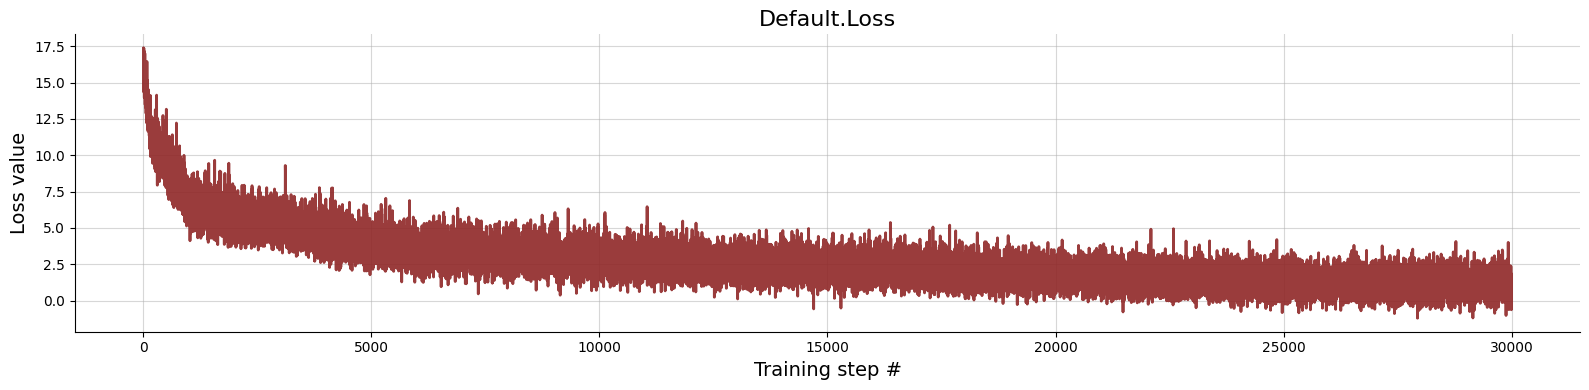

In [49]:
f = bf.diagnostics.plot_losses(history)

At some point around training step $25000$, the loss stopped decreasing, indicating that there is not much to learn from further simulation and we can continue with some diagnostics. Thus, if we wanted to increase performance at this point, we would probably make the networks more expressive than train with more simulations.

Let us now proceed with our amortized Bayesian workflow.

## Validation <a class="anchor" id="validation"></a>


### Simulation-Based Calibration <a class="anchor" id="simulation_based_calibration"></a>

As a small world (i.e. before seeing real data) sanity check, we could test the computational faithfulness of our model - neural network combination. We do this with simulation-based calibration (SBC; for more details see, [Talts et al. 2018](https://arxiv.org/abs/1804.06788); [Säilynoja et al. 2021](https://arxiv.org/abs/2103.10522)).

Again, `BayesFlow` has us covered with some pre-packaged functions to compute and visualize the calibration.

For SBC, I always opt for at least a 10:1 ratio between number of simulations and number of posterior samples.

In [50]:
# Generate some validation data
validation_sims = configurator(model(batch_size=1000))

# Extract unstandardized prior draws and transform to original scale
prior_samples = validation_sims["parameters"] * prior_stds + prior_means

Note, that our generative model is simulating data sets with a random number of trials:

In [70]:
print(
    f"Estimation will be performed on data sets with {validation_sims['summary_conditions'].shape[1]} simulated trials."
)

Estimation will be performed on data sets with 257 simulated trials


In [51]:
# Generate 100 posterior draws for each of the 1000 simulated data sets
post_samples = amortizer.sample(validation_sims, n_samples=100)

# Unstandardize posterior draws into original scale
post_samples = post_samples * prior_stds + prior_means

Note, that this is the moment where **amortized inference** really shines. We were able to perform posterior inference on $1000$ data sets within a matter of seconds.

**Rank Histograms**

If we are able to obtain unbiased posterior distributions, we should observe approximately uniform rank statistic histograms

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 10.                    Confidence intervals might be unreliable!


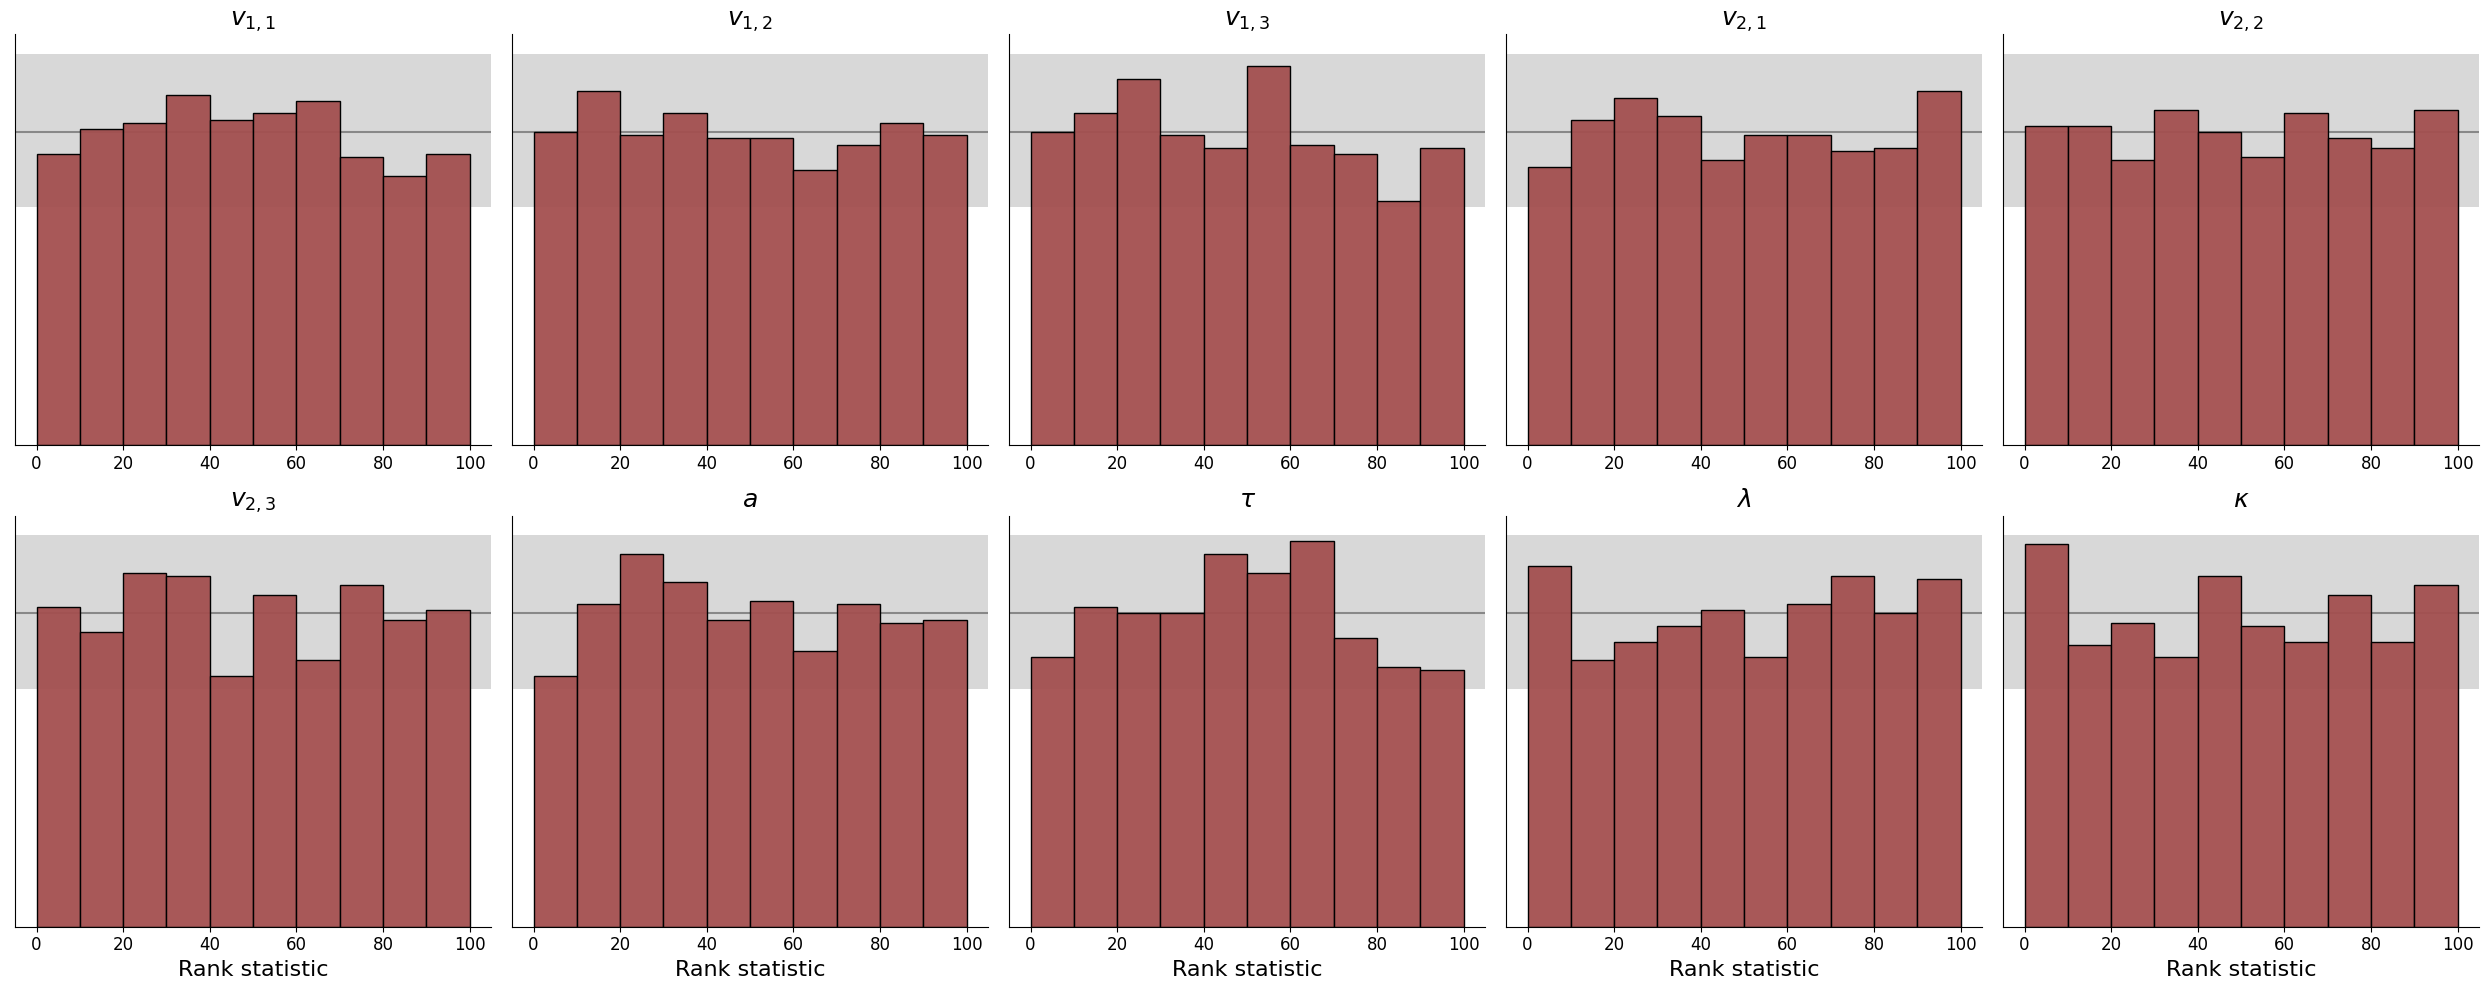

In [54]:
f = bf.diagnostics.plot_sbc_histograms(post_samples, prior_samples, num_bins=10, param_names=PARAM_NAMES)

**Rank ECDFs**

The `num_bins` hyperparameter for the construction of SBC rank histograms can be difficult to choose, despite existing heuristics. An alternative diagnostic approach for calibration is through empirical cumulative distribution functions (ECDF) of rank statistics.

Using the `difference=True` parameter, we can tell the function to compute ECDF differences for a more dynamic visualization range.

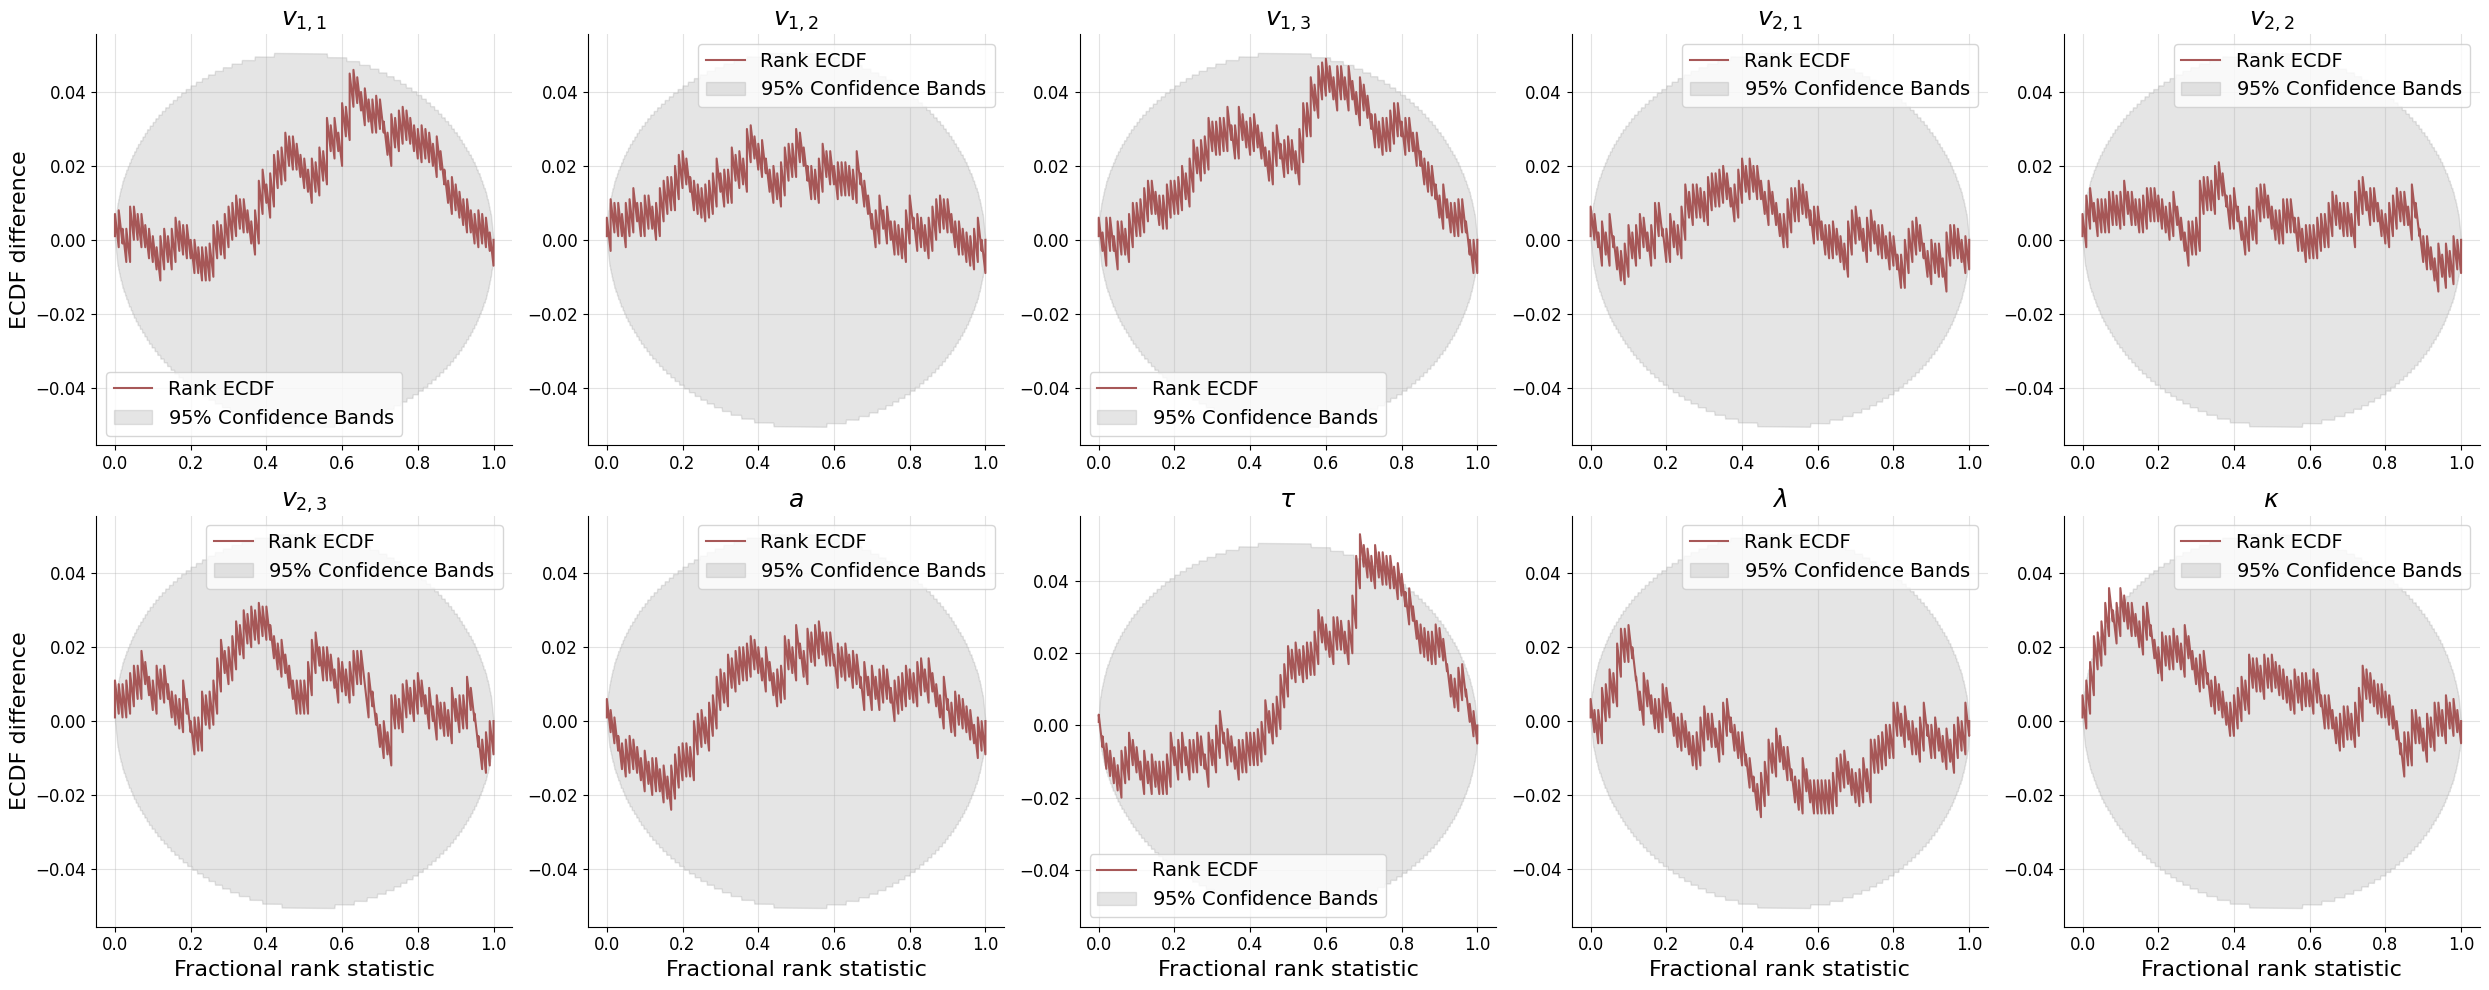

In [55]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples, prior_samples, stacked=False, difference=True, param_names=PARAM_NAMES)

Hooray, both methods indicate that our approximator is more or less well calibrated!

### Model Sensitivity <a class="anchor" id="model_sensitivity"></a>

Being able to recover the true data generating parameters is very important in cognitive modeling. If a parameter cannot be recovered with reasonable precision of some posterior expectation (e.g., the mean), then we are not allowed to make any psychological interpretation based on the estimate of this parameter. Further, we can consider to remove this parameter from the model.

We can test this *in silico* via the `plot_recovery` function in the `diagnostics` module. For instance, we can compare how well posterior means recover the true parameter. Below, we re-use the $1000$ simulations we generated for computing the rank ECDFs, but obtain a larger number of posterior draws per data set for more stable results:

In [65]:
post_samples = amortizer.sample(validation_sims, n_samples=1000)
post_samples = post_samples * prior_stds + prior_means

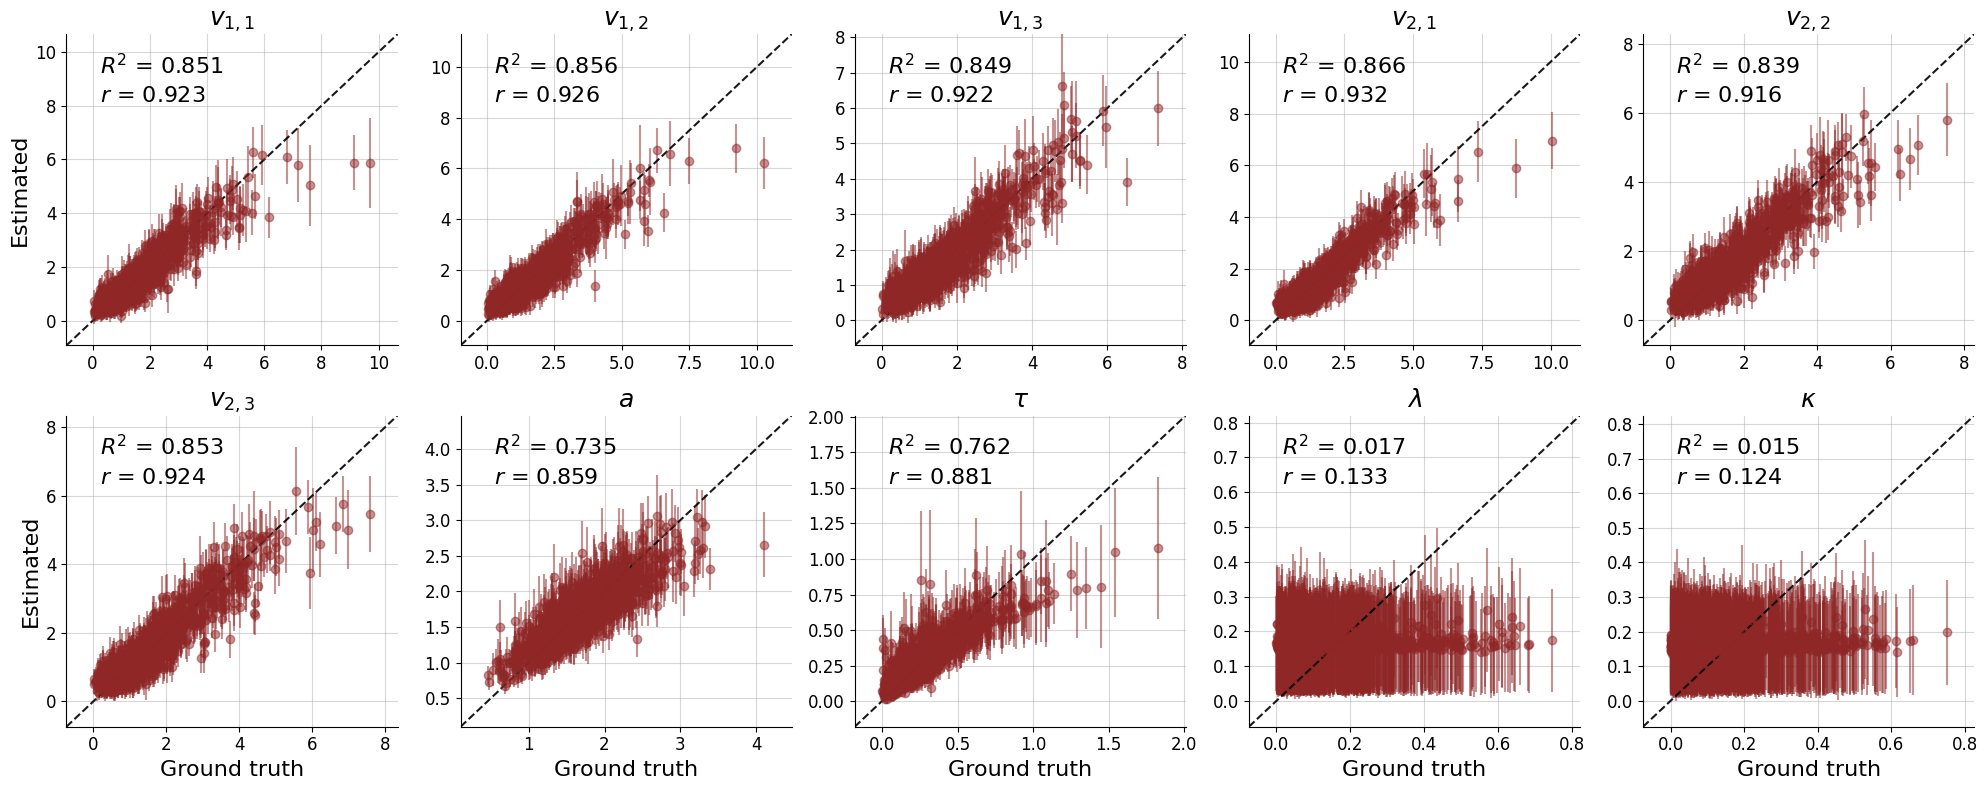

In [68]:
f = bf.diagnostics.plot_recovery(
    post_samples, prior_samples, param_names=prior.param_names, point_agg=np.mean, uncertainty_agg=np.std
)

All parameters but the decay parameter $\lambda$ and the inhibition parameter $\kappa$ can be recovered with reasonable precision by the posterior median. This is not a surprising result, as studies have shown that $\lambda$ and $\kappa$ are notoriously hard to recover. Also, we see that large parameter values are hard to recover with sufficient precision, since model sensitivity probably saturates at these values (i.e., the difference in simulator outputs between a threshold $a = 1$ and $a = 2$ is more noticeable than the one between $a = 3$ and $a = 4$.

**Idea**: Feel free to inspect point recovery with respect to a different summary of the posterior, for instance, the default posterior median and median absolute deviation (MAD).

We can look at model sensitivity more closely via another function which will plot the posterior $z$-score vs. the posterior contraction for each marginal posterior.

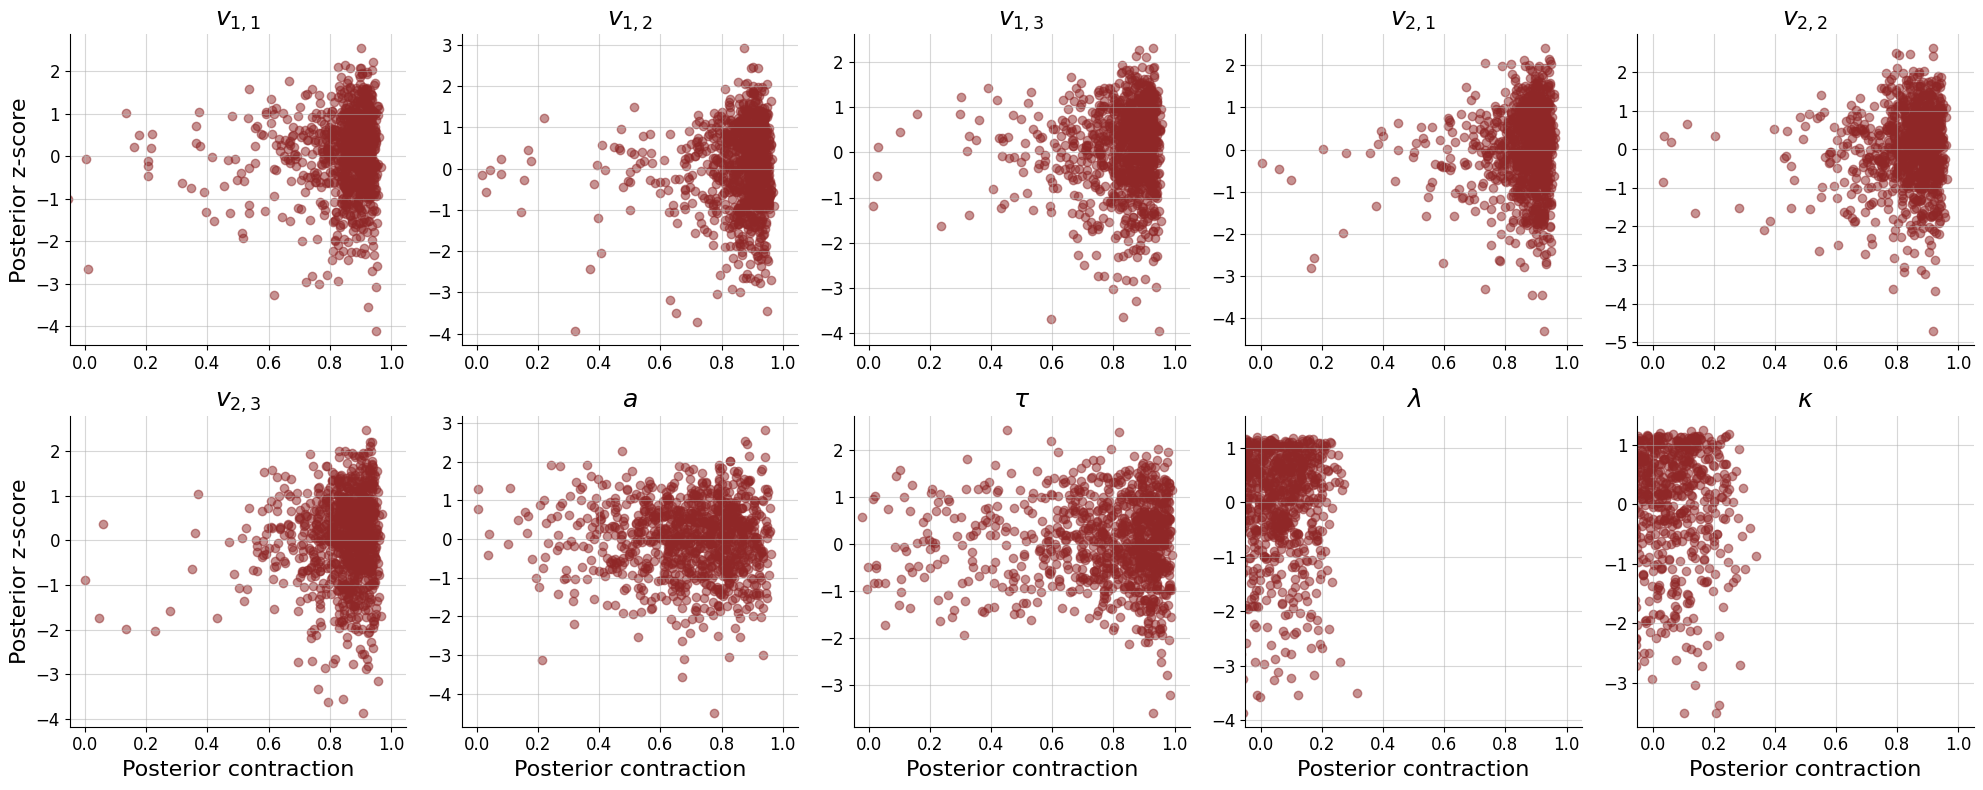

In [58]:
f = bf.diagnostics.plot_z_score_contraction(post_samples, prior_samples, param_names=prior.param_names)

### Posterior Retrodictive Checks in Silico <a class="anchor" id="posterior_retrodictive_checks"></a>

Alright, let us now gauge the predictive performance of our model. To this end, we do the following steps:

1. Simulate data with our generative model.
2. Fit the model to these data.
3. Resimulate new data with samples from the obtained posterior.
4. Compare (summary of) the simulated data and the resimulated data (model prediction).

Note, that is exactly the same procedure as you would do to check the generative performance of your model on experimental data, except that we use simulated instead of empirical data. We explicitly use the term "retrodictive" to indiate that we are not predicting new data, but merely assessing the ability of the posterior model to recreate the data it was fitted on.

We will assess retrodictive performance on $8$ simulated data sets, but, typically, you would use a much larger number and summarize the results both graphically and numerically. For each synthetic data set, we will draw $1000$ parameter configurations from the amortized posterior and resimulate data with $50$ parameter sets randomly sub-sampled from the full set of posterior draws.

In [59]:
# Define re-simulation settings
num_sim = 8
num_samples = 1000
num_resim = 50

**Step 1**

In [71]:
# Simulate and configure data
sim_data = model(batch_size=num_sim)
conf_data = trainer.configurator(sim_data)
num_obs = sim_data["sim_data"].shape[1]

**Step 2**

In [72]:
# Fit model -> draw 1000 posterior samples per data set
post_samples = amortizer.sample(conf_data, n_samples=num_samples)
# Unstandardize posteriors draws into original scale
post_samples_not_z = post_samples * prior_stds + prior_means

**Step 3**

In [73]:
# Generate random index for posterior parameter set selection
index_set = np.random.choice(np.arange(num_samples), size=num_resim)

# Get context of simulated data sets
context = sim_data["sim_batchable_context"]

# Re-simulate
pred_data = np.zeros((num_sim, num_resim, num_obs, 2))
for sim in range(num_sim):
    for i, idx in enumerate(index_set):
        pred_data[sim, i, :, :] = lca_experiment(post_samples_not_z[sim, idx, :], context[sim], num_obs)

**Step 4**

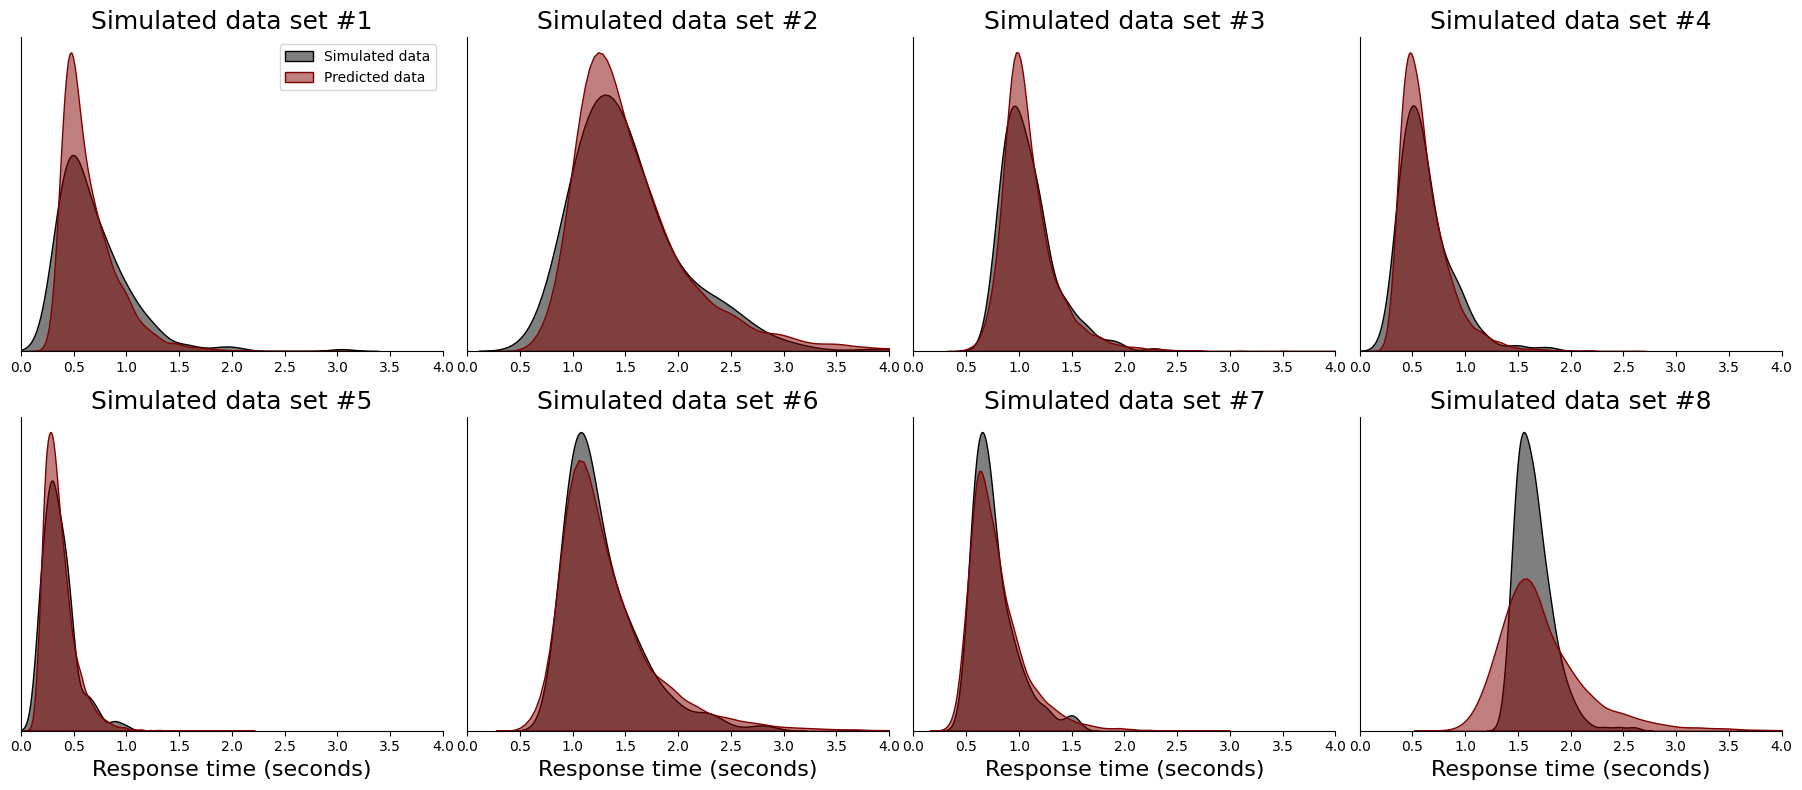

In [76]:
f, axarr = plt.subplots(2, 4, figsize=(18, 8))
for i, ax in enumerate(axarr.flat):
    sns.kdeplot(
        conf_data["summary_conditions"][i, :, 0], ax=ax, fill=True, color="black", alpha=0.5, label="Simulated data"
    )
    sns.kdeplot(pred_data[i, :, :, 0].flatten(), ax=ax, fill=True, color="maroon", alpha=0.5, label="Predicted data")
    ax.set_xlim((0, 4))
    ax.set_ylabel("")
    ax.set_yticks([])
    ax.set_title(f"Simulated data set #{i+1}", fontsize=18)
    # Set legend to first plot
    if i == 0:
        ax.legend()

    # Set x label to bottom row
    if i > (num_sim // 2) - 1:
        ax.set_xlabel("Response time (seconds)", fontsize=16)
    sns.despine()
f.tight_layout()

Comparing the kernel densities between the simulated and predicted response times, we see that we can fit synthetic data decently, but not satisfactorily. In practice, you would try to find good metrics that summarize such results (over a much larger number of simulations) numerically, in addition to the graphical checks.

At this point, you will proceed by applying your networks to actually observed data.

## Inference Phase <a class="anchor" id="inference_phase"></a>


The next step would usually be to fit the model to real empirical data and check whether the model accurately predicts the data at hand. To this end, we perform posterior retrodiction checks. As I do not have empirical data for a 3 three alternative decision-making task, I will cover the steps of the inference phase on a conceptual level.

1. Read in the data.
2. Bring the data into the same form as the simulated data we used for training the network. In our case this would mean, a multi-dimensional array with `shape = (n_sub, n_obs, 5)`. The last dimension should be in the following order: Response time, one-hot encoded choice, condition.
3. Split the data into "training" and "test" parts.
4. Fit the model to the training data.
5. Re-simulate synthetic data with the posterior samples obtained in Step 4 and compare with the training data. This is your indicator of how good the model can reproduce the data it was fitted on.
6. Re-simulate further synthetic data and comapre it with the test data (not used for estimating the posterior). This is your indicator of how good the model can predict iunseen data.
7. Create awesome visualizations.

## Further Experimentation <a class="anchor" id="further_experimentation"></a>

1. Currently, we have only performed our small world checks for a randomly samples number of trials. Test model sensitivity for the lowest and the highest number of trials. What do you observe? Which parameters are most sensitive to increasing number of observations?
2. Try a two-step learning approach. First, generate an offline data set with a very small number of trials and train the networks until convergence. Then, continue training using online learning with realistic numbers of trials. How does this approach perform compared? Do you get faster training and similar performance?
3. Change the `SetTransformer` to a `DeepSet` architecture. Does the one summary network type perform better than the other?
4. Change the `coupling_design` argument of the `InvertibleNetwork` to `spline` and re-train. Can you get better uncertainty reduction and more precise point estimates?
